In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
width = 28
height = 28
channels = 1

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

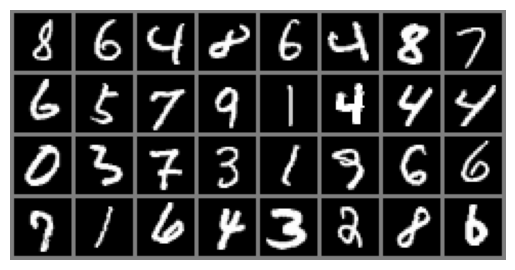

    8     6     4     8     6     4     8     7 
    6     5     7     9     1     4     4     4 
    0     3     7     3     1     9     6     6 
    7     1     6     4     3     2     8     6 


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for j in range(batch_size):
    print('%5s' % labels[j].item(), end = ' ')
    if j % 8 == 7:
        print()

In [5]:
class Generator(nn.Module):
    def __init__(self, init_size = 7):
        super(Generator, self).__init__()

        self.l1 = nn.Sequential(
            nn.Linear(100, 128 * init_size * init_size),
            nn.LeakyReLU(0.18)
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, 5, padding = 'same'),
            nn.LeakyReLU(0.18),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64, 1, 5, padding = 'same'),
            nn.Tanh(),
        )

        self.init_size = init_size

    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(x)
        return img

In [6]:
G = Generator().cuda()
summary(G, (100, ), batch_size = -1, device = 'cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
          Upsample-3          [-1, 128, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]         204,864
         LeakyReLU-5           [-1, 64, 14, 14]               0
          Upsample-6           [-1, 64, 28, 28]               0
            Conv2d-7            [-1, 1, 28, 28]           1,601
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.87
Params size (MB): 3.20
Estimated Total Size (MB): 4.08
----------------------------------------------------------------
_____________________ Generator Created___

In [7]:
class Discriminator(nn.Module):
    def __init__(self, last_size = 7):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride = 2, padding = 2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, 5, stride = 2, padding = 2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Flatten(),
        )

        self.last_size = 7
        
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * last_size * last_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [8]:
D = Discriminator().cuda()
summary(D, (1, 28, 28), batch_size = -1, device = 'cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
         Dropout2d-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

In [9]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
weight_decay = 8e-8
epochs = 20

optimizer_G = optim.Adam(G.parameters(), lr = lr, betas = (beta1, beta2), weight_decay = weight_decay)
optimizer_D = optim.Adam(D.parameters(), lr = lr, betas = (beta1, beta2), weight_decay = weight_decay)

adversarial_loss = nn.BCELoss().cuda()

losses_G = []
losses_D = []
samples = []

In [10]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start = 1):

        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad = False)

        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        optimizer_G.zero_grad()

        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
        gen_imgs = G(z)
        
        g_loss = adversarial_loss(D(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i == len(trainloader):
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: % f]" 
                  % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
                 )

            losses_D.append(g_loss.item())
            losses_G.append(d_loss.item())
            samples.append(gen_imgs)

C:\Users\Dell 5520\AppData\Local\Temp\ipykernel_16912\3665677841.py:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)


[Epoch 0/20] [Batch 1875/1875] [D loss: 0.000018] [G loss:  12.598713]
[Epoch 1/20] [Batch 1875/1875] [D loss: 0.000095] [G loss:  10.665083]
[Epoch 2/20] [Batch 1875/1875] [D loss: 0.000013] [G loss:  12.453400]
[Epoch 3/20] [Batch 1875/1875] [D loss: 0.511142] [G loss:  0.944761]
[Epoch 4/20] [Batch 1875/1875] [D loss: 0.680908] [G loss:  1.243144]
[Epoch 5/20] [Batch 1875/1875] [D loss: 0.609713] [G loss:  1.080081]
[Epoch 6/20] [Batch 1875/1875] [D loss: 0.669136] [G loss:  0.991411]
[Epoch 7/20] [Batch 1875/1875] [D loss: 0.645737] [G loss:  1.052770]
[Epoch 8/20] [Batch 1875/1875] [D loss: 0.619175] [G loss:  1.063949]
[Epoch 9/20] [Batch 1875/1875] [D loss: 0.491813] [G loss:  1.192643]
[Epoch 10/20] [Batch 1875/1875] [D loss: 0.577618] [G loss:  0.838618]
[Epoch 11/20] [Batch 1875/1875] [D loss: 0.587630] [G loss:  0.952105]
[Epoch 12/20] [Batch 1875/1875] [D loss: 0.654755] [G loss:  1.115924]
[Epoch 13/20] [Batch 1875/1875] [D loss: 0.625895] [G loss:  1.208523]
[Epoch 14/20]

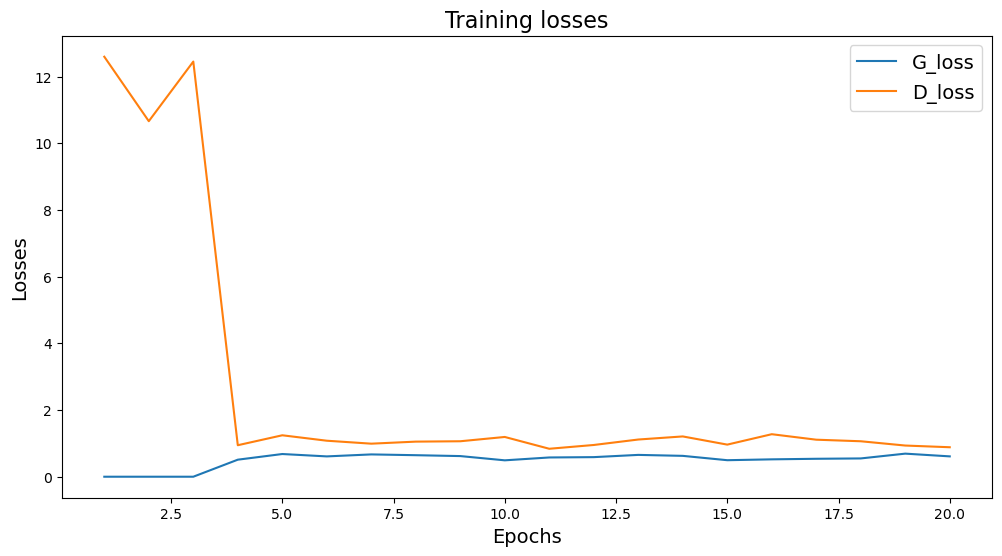

In [11]:
epochs_range = range(1, len(losses_G) + 1)

plt.figure(figsize = (12, 6))

plt.plot(epochs_range, losses_G, label = "G_loss")
plt.plot(epochs_range, losses_D, label = "D_loss")

plt.title("Training losses", fontsize = 16)
plt.legend(loc = "upper right", fontsize = 14)

plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Losses", fontsize = 14)

plt.show()

    ____________________ Step = 0 ____________________


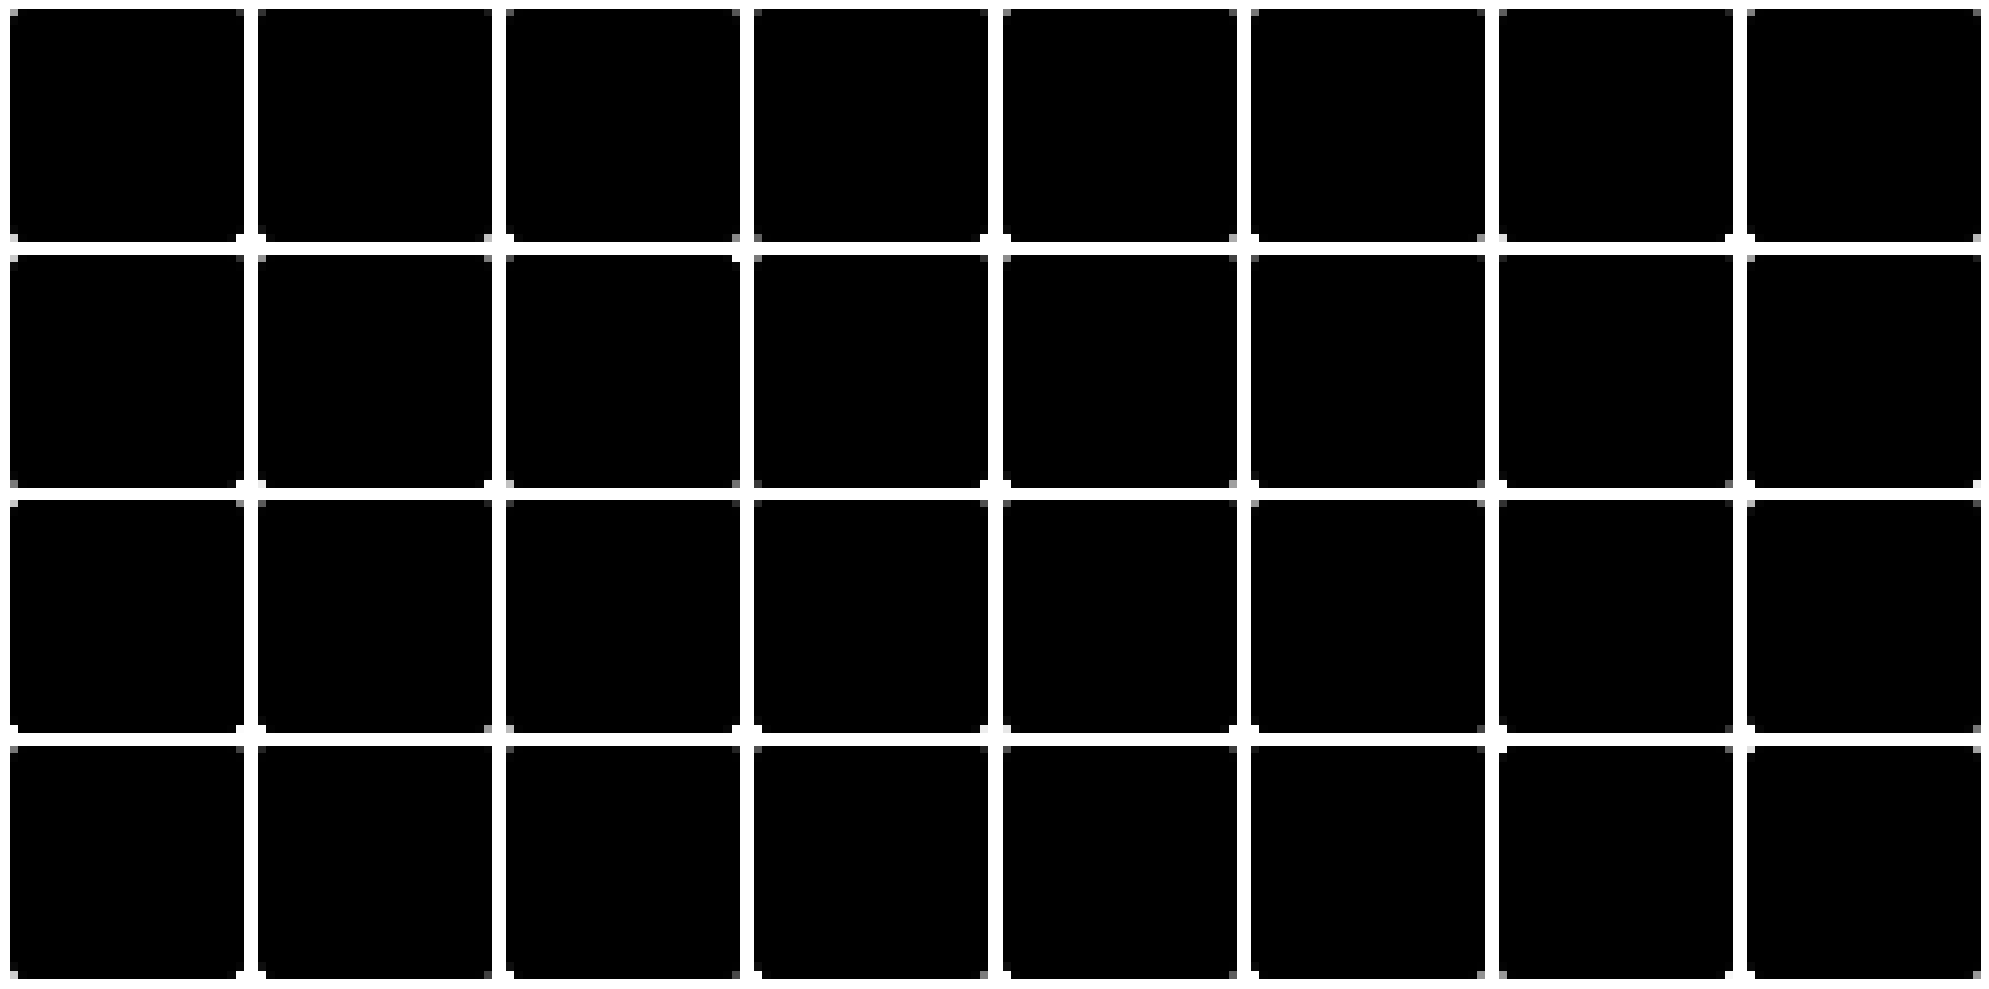



    ____________________ Step = 5 ____________________


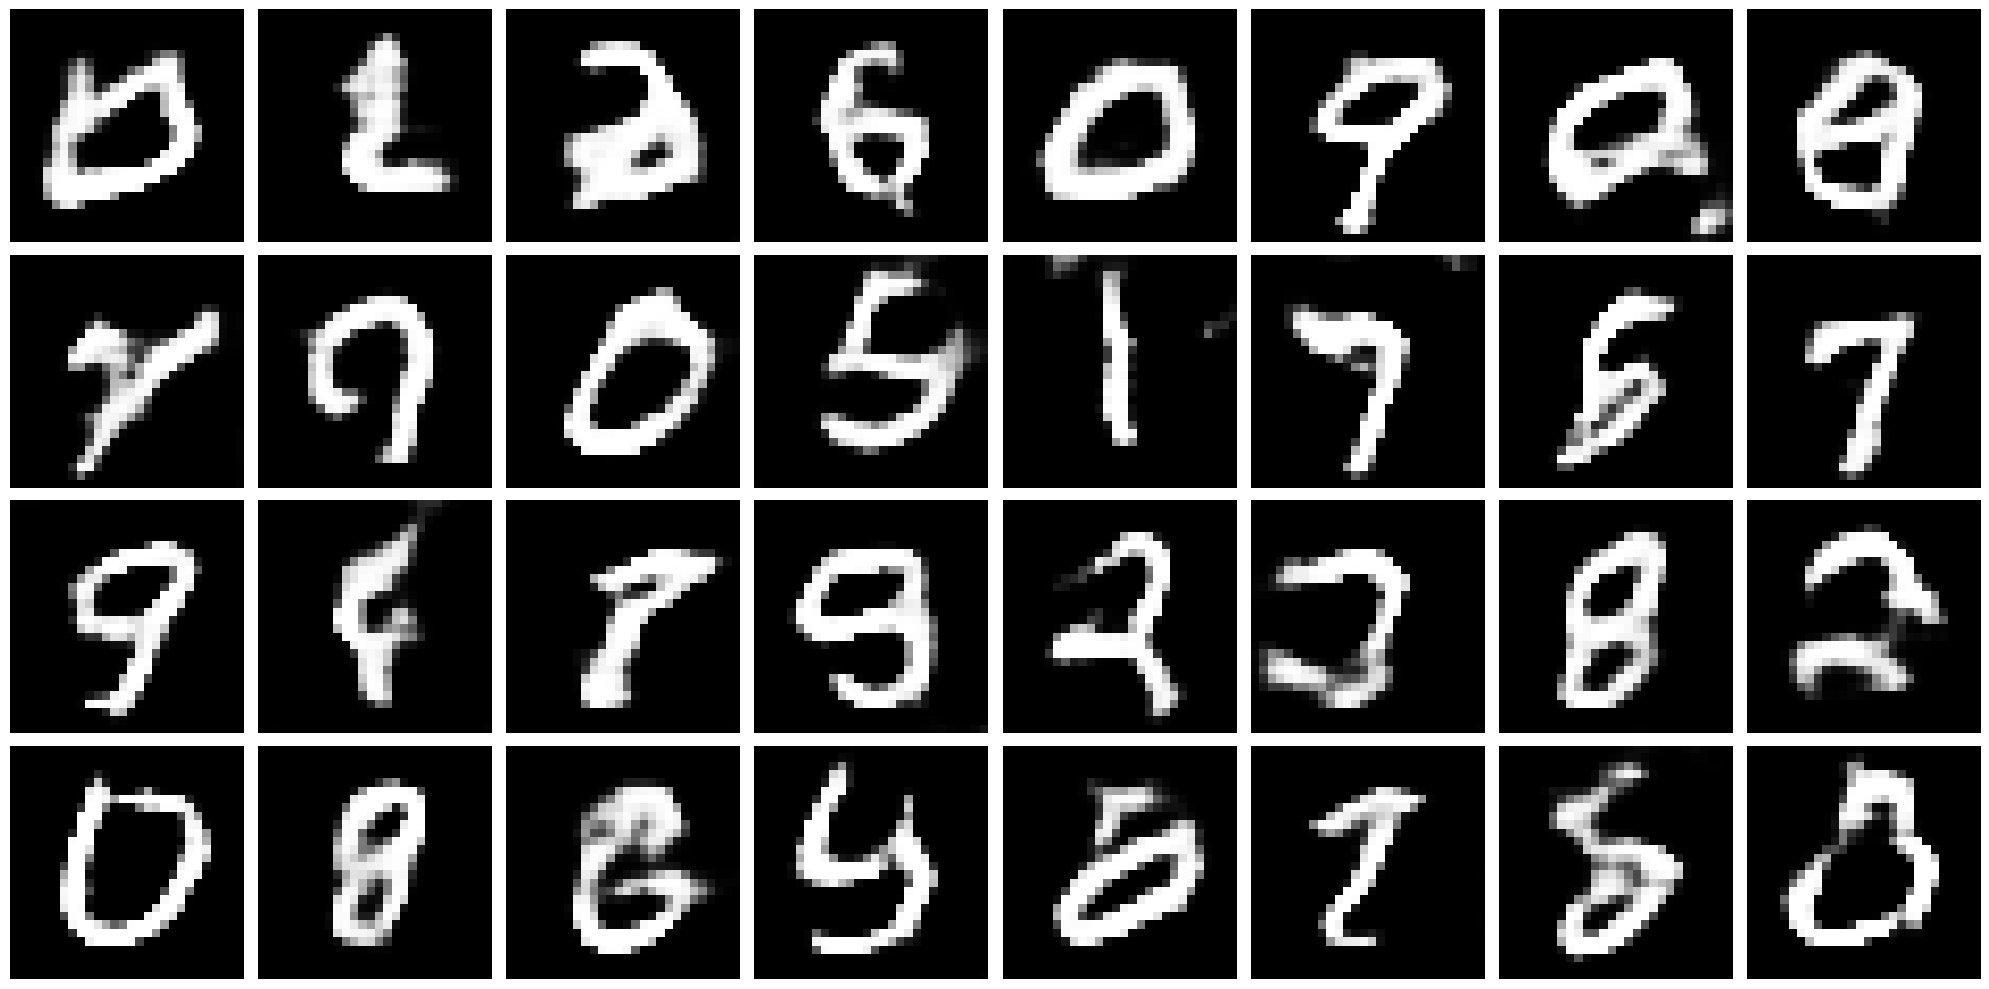



    ____________________ Step = 10 ____________________


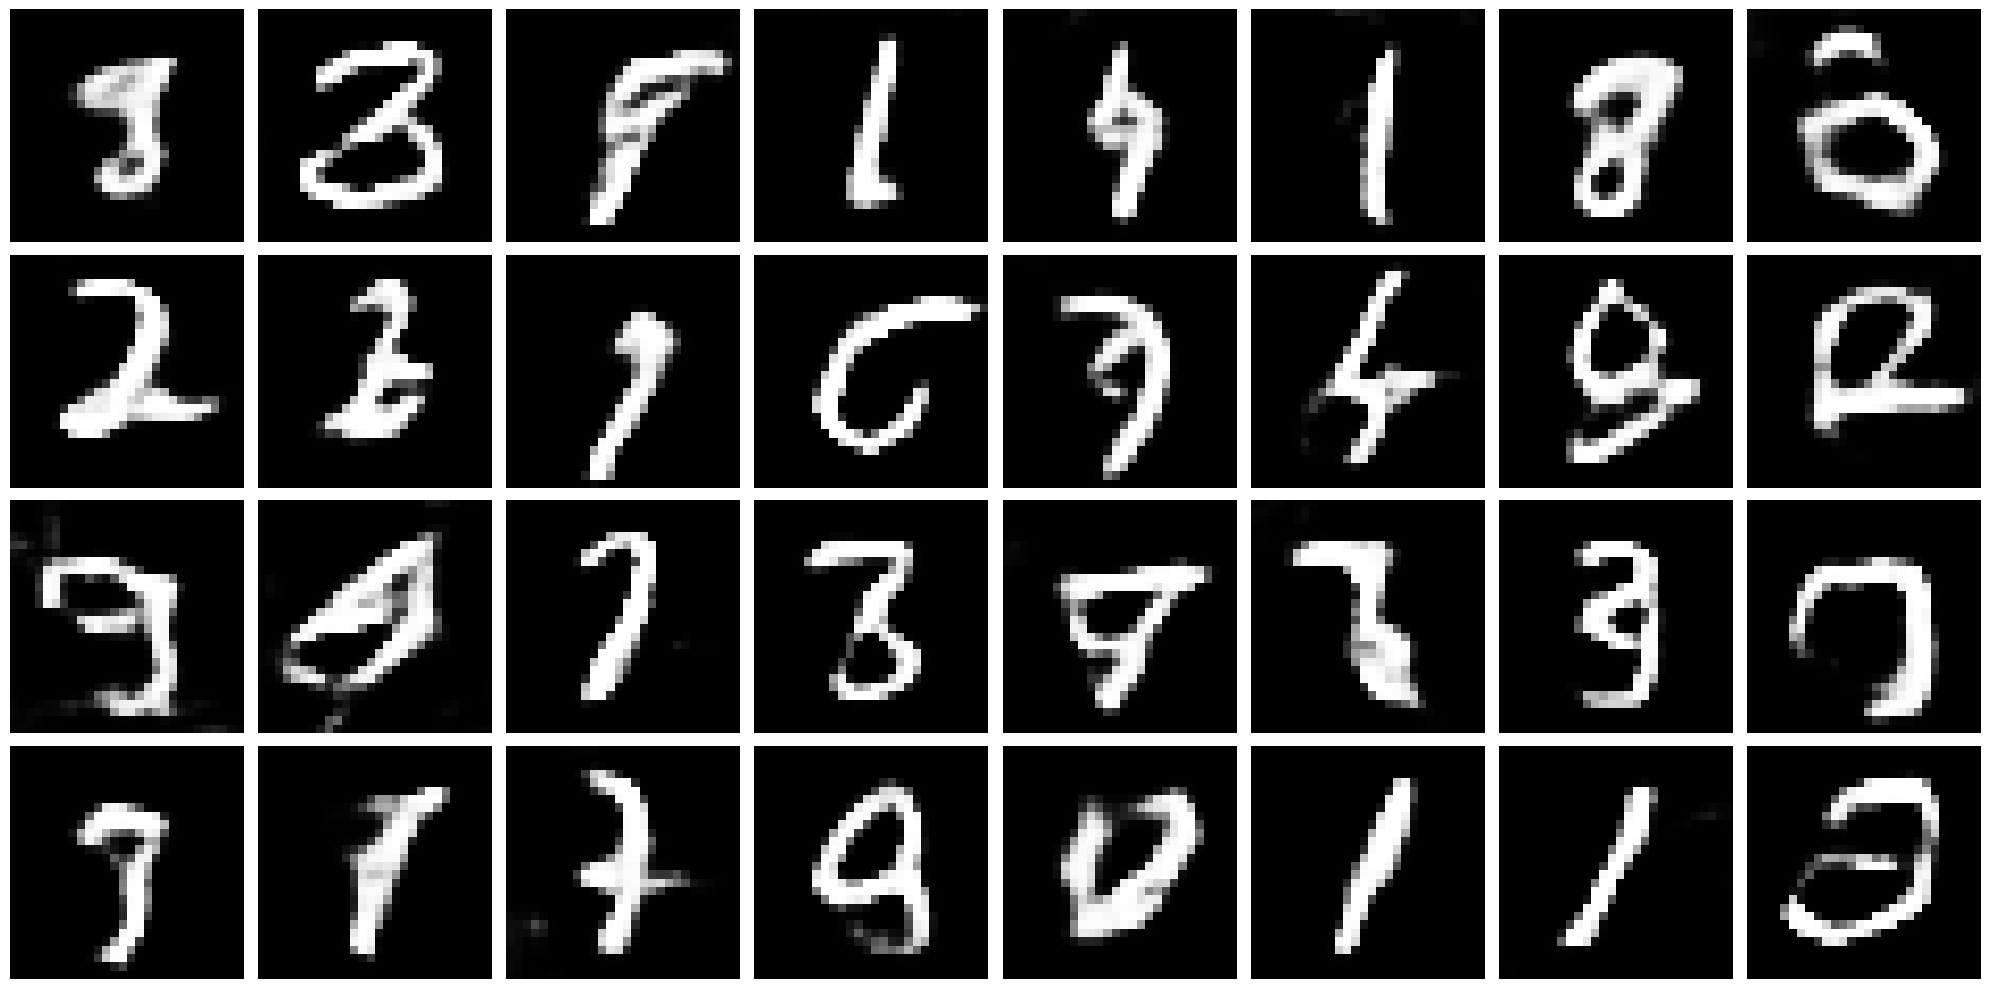



    ____________________ Step = 15 ____________________


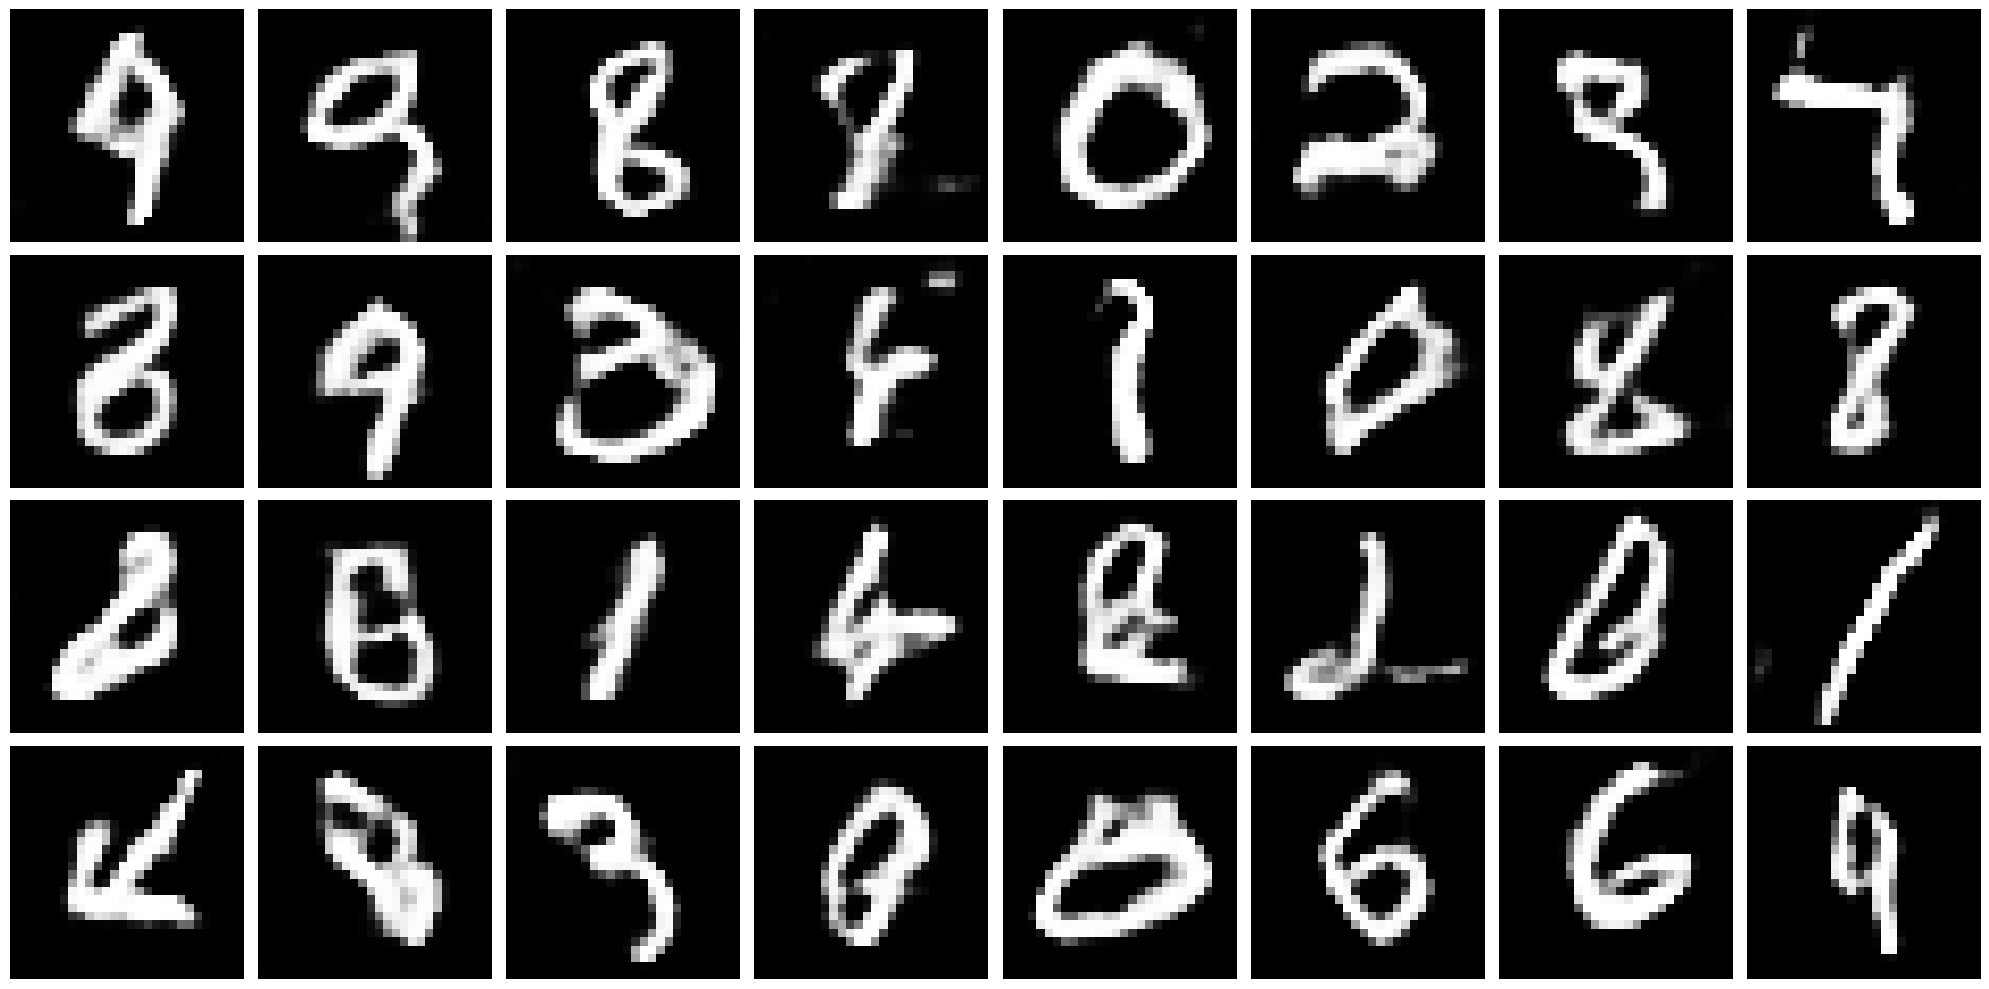

In [12]:
for idx in range(0, len(samples), 5):
    images = samples[idx].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % idx)
    
    plt.figure(figsize = (20, 10))
    
    for i in range(batch_size):
        plt.subplot(4, 8, i+1)
        image = images[i]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    print("\n")

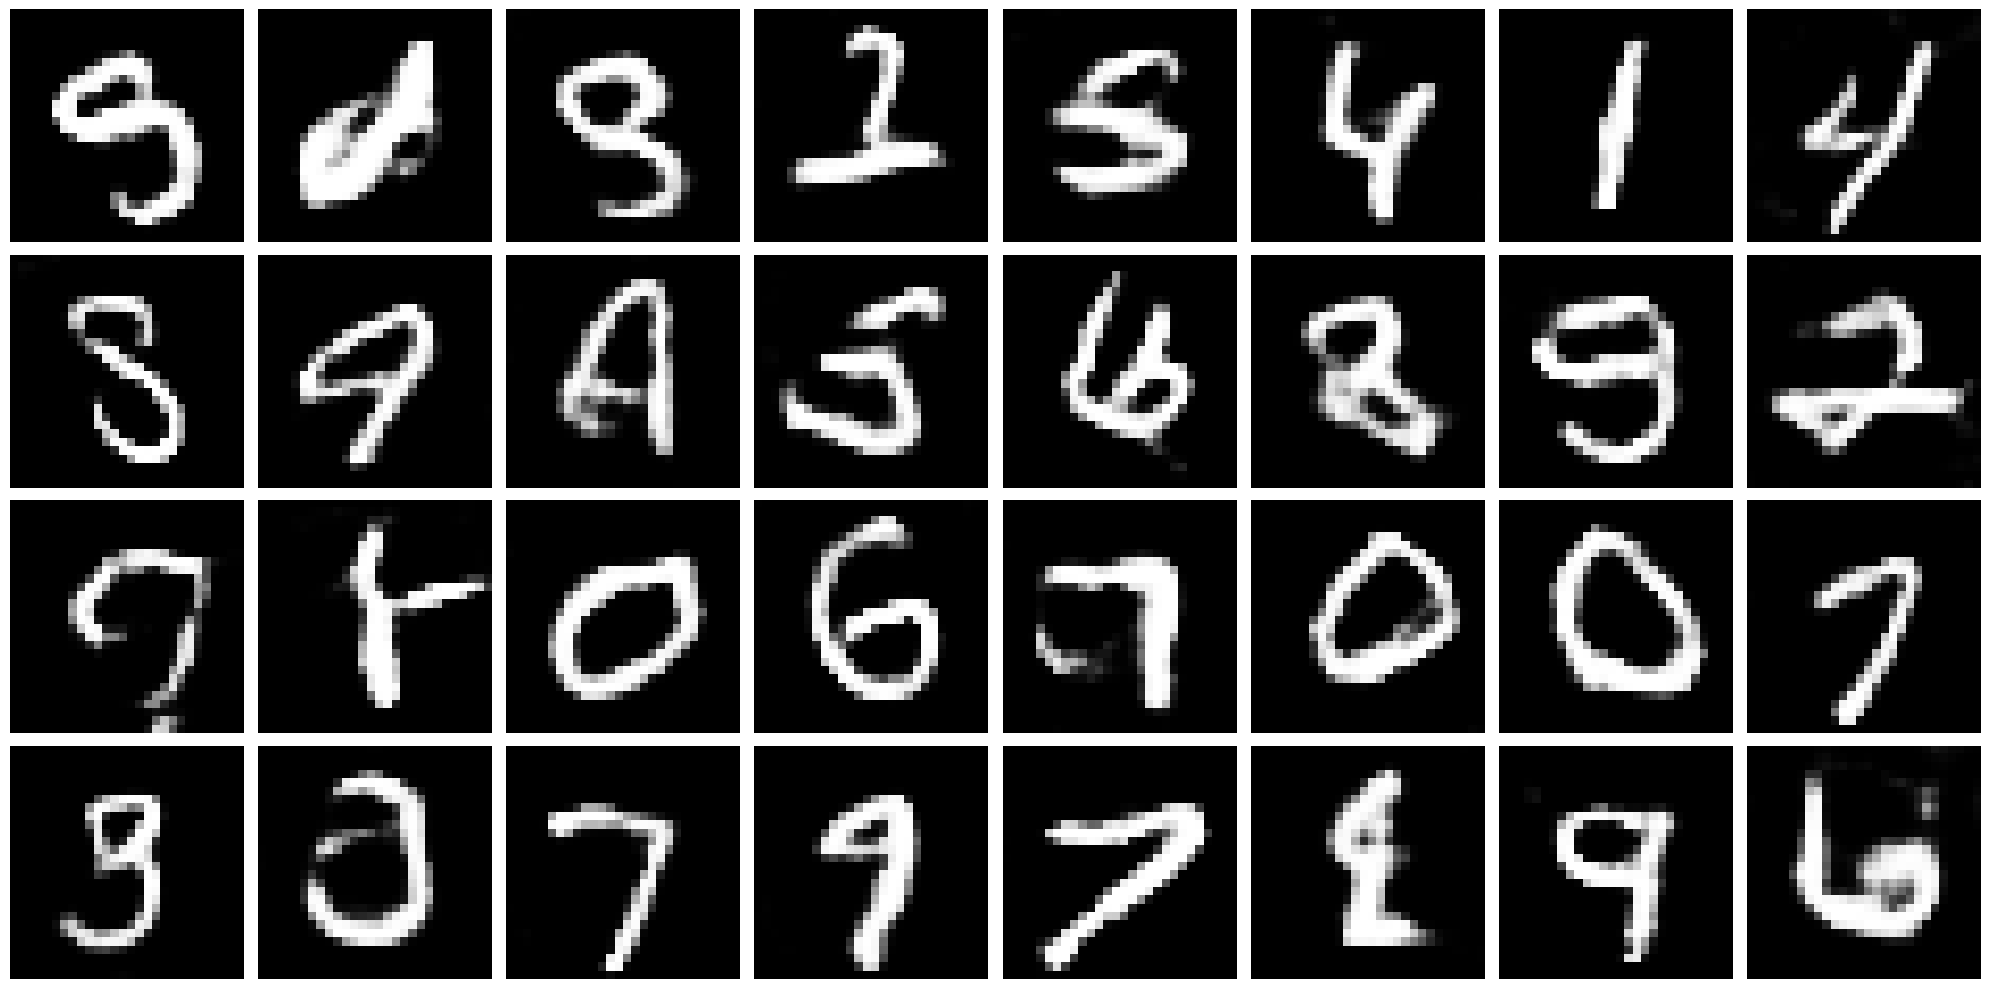

In [13]:
noise = torch.Tensor(np.random.normal(0, 1, (batch_size, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()

plt.figure(figsize = (20, 10))

for i in range(batch_size):
    plt.subplot(4, 8, i + 1)
    image = images[i]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')

plt.tight_layout()
plt.show()